# [ VAE ] OOD Detection using FSS

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_VAE
from core.data_loader import TRAIN_loader, TEST_loader
from core.custom_loss import KL_div, VAE_loss_pixel
from core.fisher_utils_VAE import Calculate_fisher_VAE, Calculate_score_VAE, AUTO_VAE
from core.fisher_utils_VAE import Calculate_fisher_VAE_ekfac, Calculate_score_VAE_ekfac
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# fix a random seed
seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# VAE - CIFAR10 & FMNIST

## [1] Load the model & Parameter Selection

In [2]:
opt = config.VAE_fmnist
netE, netG = load_pretrained_VAE(option=opt.train_dist, num=1, ngf=32, nz=100, beta=1, augment='hflip', epoch=100)
netE.eval()
netG.eval()
modules = [] # Write the name of modules you want to see

## [2] Compute ROSE via EKFAC

In [3]:
method = 'ekfac(max)'
auroc = {}
SCOREs = {}

U_A, U_B, S, mean, std = Calculate_fisher_VAE_ekfac(netE, netG, opt, select_modules=modules, max_iter=10)

for ood in opt.ood_list:
    score = Calculate_score_VAE_ekfac(netE, netG, opt, U_A, U_B, S, ood, max_iter=5000)
    temp = []
    for name in score.keys():
        a = np.array(score[name])
        a = (a - mean[name]) / std[name]  
        #a /= std[name]  
        temp.append(a) 
        #plt.figure()
        #plt.title(f'{opt.train_dist}_{ood}_{name}')
        #plt.hist(a, bins=100)
        #plt.show()
    score = np.max(np.concatenate(temp, 1), 1)
    SCOREs[ood] = score
    args = [SCOREs[opt.train_dist], SCOREs[ood]]
    labels = [opt.train_dist, ood]
    auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    print(f'{opt.train_dist}/{ood} {auroc[ood]}')
auroc
    

Calculate A, B:   0%|                                                                                                                                                                                                                           | 0/60000 [00:00<?, ?step/s]

(0): Conv2d(128, 100, kernel_size=(4, 4), stride=(1, 1))
(1): Conv2d(128, 100, kernel_size=(4, 4), stride=(1, 1))
(2): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
(3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
(4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of fmnist:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 4999/10000 [00:32<00:32, 153.76step/s]


Average Inference Time : 0.006507169399999999 seconds
Average #Images Processed : 153.67665086450648 Images
fmnist/fmnist 0.5
Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score of svhn:   0%|                                                                                                                                                                                                                  | 0/26032 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of celeba:   0%|                                                                                                                                                                                                                | 0/19141 [00:00<?, ?step/s]C:\Users\shinyp

fmnist/svhn 0.86070914


Calculate Score of lsun:   0%|                                                                                                                                                                                                                  | 0/10000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of lsun:   0%|▏                                                                                                                                                                                                       | 12/10000 [00:00<01:30, 110.50step/s]

fmnist/celeba 0.8478572


Calculate Score of lsun:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 4999/10000 [00:42<00:42, 116.46step/s]


fmnist/lsun 0.8039178600000001
Files already downloaded and verified


Calculate Score of cifar10:   0%|                                                                                                                                                                                                               | 0/10000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of mnist:   0%|                                                                                                                                                                                                                 | 0/10000 [00:00<?, ?step/s]C:\Users\shinyp

fmnist/cifar10 0.79301164


Calculate Score of kmnist:   0%|                                                                                                                                                                                                                | 0/10000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of kmnist:   0%|▎                                                                                                                                                                                                     | 16/10000 [00:00<01:05, 152.74step/s]

fmnist/mnist 0.78559516


Calculate Score of kmnist:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 4999/10000 [00:32<00:32, 154.38step/s]


fmnist/kmnist 0.81641324
Files already downloaded and verified


Calculate Score of omniglot:   0%|                                                                                                                                                                                                              | 0/13180 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of notmnist:   0%|                                                                                                                                                                                                              | 0/18724 [00:00<?, ?step/s]C:\Users\shinyp

fmnist/omniglot 0.99999856


Calculate Score of noise:   0%|                                                                                                                                                                                                                 | 0/10000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of noise:   0%|▎                                                                                                                                                                                                      | 15/10000 [00:00<01:09, 144.58step/s]

fmnist/notmnist 0.9804207199999999


Calculate Score of constant:   0%|                                                                                                                                                                                                              | 0/10000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of constant:   0%|▎                                                                                                                                                                                                   | 16/10000 [00:00<01:03, 156.79step/s]

fmnist/noise 0.39719102


Calculate Score of overall:   0%|                                                                                                                                                                                                               | 0/10000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of overall:   0%|▎                                                                                                                                                                                                    | 14/10000 [00:00<01:15, 132.36step/s]

fmnist/constant 0.89083464


Calculate Score of overall:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 4999/10000 [00:36<00:36, 135.45step/s]

fmnist/overall 0.81548312


{'fmnist': 0.5,
 'svhn': 0.86070914,
 'celeba': 0.8478572,
 'lsun': 0.8039178600000001,
 'cifar10': 0.79301164,
 'mnist': 0.78559516,
 'kmnist': 0.81641324,
 'omniglot': 0.99999856,
 'notmnist': 0.9804207199999999,
 'noise': 0.39719102,
 'constant': 0.89083464,
 'overall': 0.81548312}

In [ ]:
# Sampling Robustness (Overall AUROC)

Sampling['fmnist'] = {
    '10': 0.815,
    '50': ,
    '100': ,
    '500': ,
    '1000': ,
    '5000': ,
    '10000': ,
}

Sampling['cifar10'] = {
    '10': 0.815,
    '50': ,
    '100': ,
    '500': ,
    '1000': ,
    '5000': ,
    '10000': ,
}

## [3] Save the result score (see the directory npy/ROSE)

In [7]:
for ood in opt.ood_list:
    score_path = f'./npy/ROSE/VAE_{opt.train_dist}/{opt.train_dist}_{ood}_{method}.npy'
    np.save(score_path, SCOREs[ood])

## [4] View scores for each layer

In [8]:
# Just show scores
# plot_scores_all_layers(train_dist, params, SCOREs, opt, save=True)


## [5] Check the reconstruction ability of VAE

Files already downloaded and verified


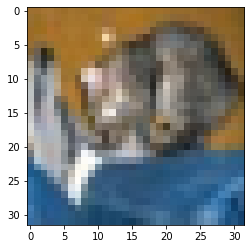

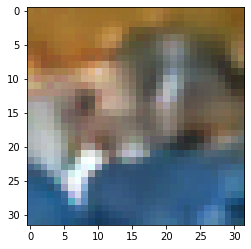

In [9]:
# Check the ability of reconstruction
loader = TEST_loader('cifar10', 'cifar10')
for i,(x,_) in enumerate(loader):
    z, mu, logvar = netE(x.cuda())
    y = netG(z)
    plt.figure()
    plt.imshow(x[0].permute(1, 2, 0).detach().cpu())
    plt.show()
    plt.figure()
    plt.imshow(torch.argmax(y, 4)[0].permute(1, 2, 0).detach().cpu())
    plt.show()
    if i == 0:
        break